# Tissue Patterning

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

# conda install ipywidgets for movie 
from ipywidgets import interact, FloatSlider, IntSlider

In [2]:
%matplotlib inline

## 1. Emergent properties of collective gene-expression patterns in multicellular systems
Smart, M., & Zilman, A. (2023). Emergent properties of collective gene-expression patterns in multicellular systems. *Cell Reports Physical Science*, 101247.
[Paper Link](https://doi.org/10.1016/j.xcrp.2023.101247)
### 1.1 Single-cell model
Assume cell state is described by the activity of $N$ genes in the cell. Let $\xi_1, \ldots, \xi_N$ denotes the desired cell types, with $\xi_i\in\{1,-1\}^N$. Let $\hat{J}=\xi(\xi^{T}\xi)^{-1}\xi^T$ represent the gene-gene interactions. 
* First, we want to show that $\xi_i$ is the eigenvector of matrix $\hat{J}$. That is to show that $$\hat{J}\xi_i=\lambda_i\xi_i.$$
Let $A=(\xi^{T}\xi)^{-1}\xi^T$. Note that 
$$A\xi=(\xi^{T}\xi)^{-1}\xi^T\xi=I.$$
This implies the following,
\begin{align*}
\hat{J}\xi&=\xi A \xi\\
&=\xi I\\
&=I\xi.
\end{align*}
Therefore, $\xi_i$ are eigenvectors of matrix $\hat{J}$ for the repeated eigenvaule $\lambda=1$.


* Next, to get the final gene-gene interaction matrix J, the authors set the diagonal value to zero. That is,
$$J=\hat J - \text{diag}(\hat J).$$
Assuming all entries of matrix $\hat J$ are the same, the above transformation won't change the eigenspace of the matrix. But, is it guaranteed all diagonal entries are the same? 

In [3]:
import numpy as np
import random
from numpy.linalg import inv
from scipy.stats import bernoulli
from numpy import linalg as LA

N = 5  # number of genes
assert N == 5  # parts of code below assume 4 genes; TODO: generalize

# Construct the gene-gene interaction matrix J
xi1 = np.array([-1,1,-1,1,1])
xi2 = np.array([-1,1,1,1,-1])

# xi1 = np.array([ 1, 1, 1,-1,-1,-1,-1,-1,-1])
# xi2 = np.array([-1,-1,-1, 1,-1,-1,-1,-1,-1])
# xi3 = np.array([-1,-1,-1,-1,-1,-1, 1, 1, 1])

xi = np.stack((xi1, xi2), axis=-1)
Jhat = xi @ inv(xi.T @ xi) @ xi.T
J = Jhat - np.diag(np.diag(Jhat))
print('example evec:', Jhat @ xi2)

example evec: [-1.  1.  1.  1. -1.]


### 1.2 Single Cell Hamiltonian

$$\mathcal{H}(s_0)= -\frac12(s^TJs) - h^Ts$$

In [4]:
# Generate all possible states of the cell and verify the lowest energy state in a single cell
xn = xi1.shape[0]
comb = np.tile([-1,1], (xn, 1)).tolist()
S = np.stack(np.meshgrid(*comb), -1).reshape(-1, xn).T
H = np.diag(-S.T @ J @ S/2)
ind_xi = np.where(abs(H - H.min())<1e-6)[0]
print("The energy for all cell states are", np.round(H,2))
print("The lowest energy states in a single cell are the column vectors of matrix:\n", S[:, ind_xi])
print("The global minimum are cell states with ID:", ind_xi)

ind_glob_max = np.where(abs(H - H.max())<1e-6)[0]
print("The global maximum are cell states with ID:", ind_glob_max)

ind_neighb = [sum(abs(np.tile(S[:,i],(2**N,1)).T - S)) == 2 for i in range(2**N)]
local_min = np.array([sum((H[i]-1e-6)<=H[ind_neighb[i]]) for i in range(2**N)])
print("The local minimum are cell states with ID:", np.where(local_min==N)[0])

local_max = np.array([sum((H[i]+1e-6)>=H[ind_neighb[i]]) for i in range(2**N)])
print("The local maximum are cell states with ID:", np.where(local_max==N)[0])

The energy for all cell states are [ 0.83 -0.17  0.83 -0.17 -0.17  0.83 -0.17  0.83 -0.5  -1.5   0.83 -0.17
 -1.5  -0.5  -0.17  0.83  0.83 -0.17 -0.5  -1.5  -0.17  0.83 -1.5  -0.5
  0.83 -0.17  0.83 -0.17 -0.17  0.83 -0.17  0.83]
The lowest energy states in a single cell are the column vectors of matrix:
 [[ 1  1 -1 -1]
 [-1 -1  1  1]
 [-1  1 -1  1]
 [-1 -1  1  1]
 [ 1 -1  1 -1]]
The global minimum are cell states with ID: [ 9 12 19 22]
The global maximum are cell states with ID: [ 0  2  5  7 10 15 16 21 24 26 29 31]
The local minimum are cell states with ID: [ 9 12 19 22]
The local maximum are cell states with ID: [ 0  2  5  7 10 15 16 21 24 26 29 31]


### 1.3 Multicellular Model

Assume a given tissue (multicellular stystem) has $M$ different cells. Let $s_i\in\{1,-1\}^N$ represent the $i$-th cell. The Hamiltonian of the system is calculated as the following,
$$\mathcal{H}(s_1,s_2,\ldots, s_M)=\sum_i^M -\frac12(s_i^TJs_i)+\gamma \sum_i\sum_j A_{ij}f(s_i,s_j).$$
* The first term describes the summation of the Hamiltonian of each cell
* The second term describes the Hamiltonian from cell-cell interaction,
$$f(s_i,s_j)=-\frac12 s_i^TWs_j,$$
with strength $\gamma$ and randomly sampled matrix $W$.


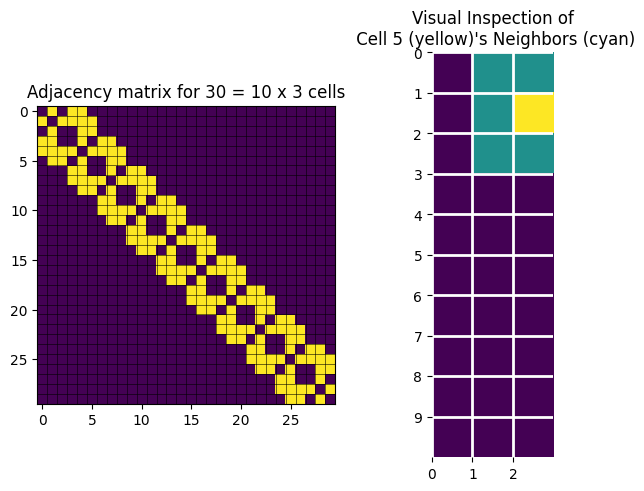

In [39]:
# Cell arrangement: m1 rows of m2 cells
m1 = 10   # no. of rows
m2 = 3    # no. of columns 
M = m1 * m2  # total number of cells

# Generating neighborhood matrix A
A = np.zeros((M, M))
k = 0
for i in np.arange(1, m1+1):
    for j in np.arange(1, m2+1):
        B = np.zeros((m1+2, m2+2))
        B[i-1:i+2, j-1:j+2] = 1
        B[i, j] = 0
        B_temp = B[1:m1+1, 1:m2+1]
        A[k, :] = B_temp.flatten()
        k += 1

# Ramdon inter-cellular communication matrix W
np.random.seed(100)
W = np.random.uniform(-1,1, (N,N))

# Print the adjacency matrix and the neighborhoood for a random cell
fig, axs = plt.subplots(1,2,layout='constrained')

axs[0].title.set_text('Adjacency matrix for %d = %d x %d cells' % (M, m1, m2))
axs[0].imshow(A, interpolation=None)
#axs[0].set(xticks=np.arange(-0.5, M-0.5, 1), yticks=np.arange(-0.5, M-0.5, 1))
for idx in range(M-1):
    pos = idx + 0.5
    axs[0].axvline(pos, color='k', linewidth=0.4)
    #axs[0].axvline(pos, color='w', linewidth=0.3)
    axs[0].axhline(pos, color='k', linewidth=0.4)
    #axs[0].axhline(pos, color='w', linewidth=0.3)
    
#axs[0].grid(color='w', linewidth=0.2)   
#axs[0].grid(color='k', linewidth=0.6)   

np.random.seed(seed=None)
i_rand = np.random.randint(M)  # pick a random cell
i_neigb = A[i_rand,]
i_neigb[i_rand] = 2

extent = (0, m2, m1, 0)
axs[1].imshow(i_neigb.reshape(m1,m2), extent=extent)
axs[1].title.set_text('Visual Inspection of\n Cell %d (yellow)\'s Neighbors (cyan)'  % i_rand)
axs[1].set(xticks=range(0, m2, 1), yticks=range(0, m1, 1))
axs[1].grid(color='w', linewidth=2)   
axs[1].set_frame_on(False)
plt.show()

In [6]:
T = 100                              # Simulation Time Steps
s_all = np.zeros((xn, M, T+1))       # Storing Transitions
gamma = 10                           # Cell-cell communication strength
beta = 2000                          # Noise strength

# Initial tissue state
#  - iterate over cells
for i in range(M):
    r = np.random.randint(len(S.T))
    s_all[:,i,0] = S.T[r]
    #s_all[:,i,0] = [1,1,-1,1]

# Stochastic update one gene at a time
for k in range(1, T+1):
    for i in range(M):
        s = np.copy(s_all[:,i,k-1])
        cell_trans = s
        for j in range(N):
            ind = A[i,:] != 0
            h = J @ s.T + gamma * np.sum(s @ W @ s_all[:,ind,k-1])
            transition_prob = 1 / ( 1 + np.exp(-2 * beta * h[j]) )
            cell_trans[j] = 2 * bernoulli.rvs(transition_prob) - 1
            s_all[j,i,k] = cell_trans[j]


C:\Users\matts\AppData\Local\Temp\ipykernel_7256\3026102855.py:21: RuntimeWarning: overflow encountered in exp
  transition_prob = 1 / ( 1 + np.exp(-2 * beta * h[j]) )


In [7]:
# Definition of the plot_tissue function, our "callback function".
def plot_tissue_integer(t):
    cell_color = [1, 2, 4, 8, 16] @ np.heaviside(s_all[:,:,t], 0)
    cell_color.resize((m1, m2))

    text_kwargs = dict(ha='center', va='center', fontsize=10, path_effects=[patheffects.withStroke(linewidth=1, foreground='black')])
    plt.imshow(cell_color, vmin=0, vmax=15)
#    plt.colorbar(ticks=np.arange(0, 2**4, 4))
    color_index_lowH = [1, 2, 4, 8, 16] @ np.heaviside(S[:,ind_xi], 0) #list the color index for cells with lowest Hamiltonian
    col_lowH = 'green'
    color_index_highH = [1, 2, 4, 8, 16] @ np.heaviside(S[:,ind_glob_max], 0) #list the color index for cells with lowest Hamiltonian
    col_highH = 'red'

    # add state text to each cell
    for i in range(m1):
        for j in range(m2):
            cell_idx = j + i * m2
            cell_color_ij = cell_color[i, j]
            if cell_color_ij in color_index_lowH:
                col= col_lowH
            elif cell_color_ij in color_index_highH:
                col= col_highH
            else:
                col = 'white'
            #cell_state = list(np.heaviside(s_all[:, cell_idx, t], 0))
            plt.text(j, i, 'c%d\n%d' % (cell_idx, cell_color[i, j]), **text_kwargs, c=col)
    plt.text(m2+1, 0.5, 'Global Max.', **text_kwargs, c=col_highH)
    plt.text(m2+1, 1.5, 'Global Min.', **text_kwargs, c=col_lowH)
    plt.show()


## Generate our user interface.
interact(plot_tissue_integer, t=IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_tissue_integer(t)>

### (Work in progress) Additional plotting tool -- scatterplot visualization of cell state (circle = gene on; absence = off)
- step 1: push state size onto nearest square; pad with zeros and mask the dummy values
- step 2: plot backdrop 'square' on gene indices of square (nothing for masked dumnmy entries)
- step 3: plot circle marker for genes that are ON (val = 1)

In [8]:
def pad_to_len_square(x, square_size):
    x_pad = np.zeros(square_size ** 2)    
    x_pad[:len(x)] = x
    return x_pad

In [9]:
def plot_rna_square(vals, ns, top_left, marker_size=100, extent=1.0, ax=None):
    """
    vals:   np.array values in -1, 1 or 0 (0 means undefined -- mask it out)
    ns:     side length of closest square s.t. ns ** 2 >= vals.size()
    top_left: x,y coordinates to place scatter plot
    marker_size: 100 (square size)
    extent: scale of marker (x, y) coordinates, which should be proportional to marker size
    """
    square_size = extent * 200 * np.ones(ns ** 2)
    circle_size = 0.25 * square_size
    
    # construct array to maps gene index to (x, y) position
    # - xv, yv construction: first gene in top left, last bottom right
    xv, yv = np.meshgrid(
        np.linspace(top_left[0], top_left[0] + extent, ns), 
        np.linspace(top_left[1], top_left[1] - extent, ns), 
        indexing='xy')

    if ax is None:
        ax = plt.figure().gca()
    
    # where vals == non-zero; squares 's'
    square_masked = np.ma.masked_where(vals == 0, square_size)
    ax.scatter(xv, yv, square_masked, marker='s', c='blue') 
    
    # where vals == 1.0;      circles 'o'
    circle_masked = np.ma.masked_where(vals != 1.0, circle_size)
    ax.scatter(xv, yv, circle_masked, marker='o', c='yellow')
    
    return

"""
s = np.array(
    [1,1,1,-1,-1,-1,1,1]
)
n = len(s)

square_size = np.ceil(np.sqrt(n)).astype(int)

#s_pad = np.zeros(square_size ** 2)
#s_pad[:n] = s
s_pad = pad_to_len_square(s, square_size)

s_sqr = s_pad.reshape(square_size, square_size)

print(s)
print(s_pad)
print(s_sqr)

plt.imshow(s_sqr)

plot_rna_square(s_pad, 3, (5, 5))
plt.show()
"""

'\ns = np.array(\n    [1,1,1,-1,-1,-1,1,1]\n)\nn = len(s)\n\nsquare_size = np.ceil(np.sqrt(n)).astype(int)\n\n#s_pad = np.zeros(square_size ** 2)\n#s_pad[:n] = s\ns_pad = pad_to_len_square(s, square_size)\n\ns_sqr = s_pad.reshape(square_size, square_size)\n\nprint(s)\nprint(s_pad)\nprint(s_sqr)\n\nplt.imshow(s_sqr)\n\nplot_rna_square(s_pad, 3, (5, 5))\nplt.show()\n'

In [10]:
# Definition of the plot_tissue function, our "callback function".
def plot_tissue_symbolic(t):
    cell_color = [1, 2, 4, 8] @ np.heaviside(s_all[:,:,t], 0)
    cell_color.resize((m1, m2))
    plt.imshow(cell_color, vmin=0, vmax=15)
    plt.colorbar(ticks=np.arange(0, 2**4, 4))
    
    square_size = np.ceil(np.sqrt(N)).astype(int)
    
    for i in range(m1):
        for j in range(m2):
            cell_idx = j + i * m2
            cell_state = s_all[:, cell_idx, t]
            cell_state_padded = pad_to_len_square(cell_state, square_size)
            
            symbol_extent = 0.2
            top_left = (j - 0.5 * symbol_extent, 
                        i + 0.5 * symbol_extent)
            plot_rna_square(cell_state_padded, square_size, top_left, ax=plt.gca(), extent=symbol_extent)
    plt.show()

## Generate our user interface.
interact(plot_tissue_symbolic, t=IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_tissue_symbolic(t)>

#### Tinkering/delete: Imshow testing (data rotation, x vs y)

In [11]:
mx = 6
my = 10
x_vec = np.arange(mx * my)
x_arr = x_vec.reshape((mx, my))

In [12]:
print(x_arr)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]]


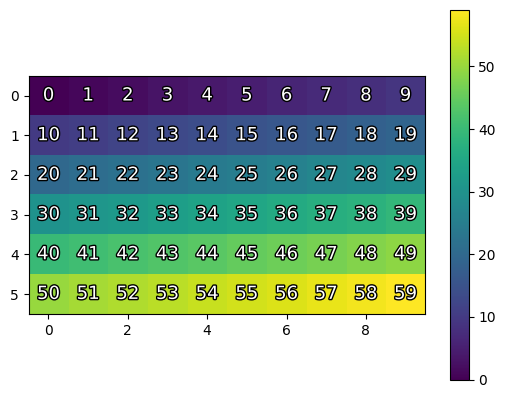

In [13]:
im = plt.imshow(x_arr)
plt.colorbar(im)
for i in range(mx):
    for j in range(my):
        cell_idx = j + i * my
        plt.text(j, i, cell_idx, fontsize=13, ha='center', va='center', c='white', 
                    path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
        #plt.text(j, i, cell_idx, fontsize=12, ha='center', c='k',
        #            path_effects=[patheffects.withStroke(linewidth=2, foreground='white')])